# How to Use Machine Learning to Categorize Dockets
> Applying Text Classification Techniques to Dockets Narratives

- toc: true 
- badges: true
- comments: true
- image: images/social_logo.png
- author: Charles Dobson
- categories: [python, artificial intelligence, machine learning, natural language processing, nlp, law, litigation]

# Introduction

In my [last post](https://www.litkm.com/python/artificial%20intelligence/machine%20learning/natural%20language%20processing/nlp/law/litigation/2022/11/14/How_to_Generate_Docket_Narratives_for_NLP_Experiments.html), I described an approach to creating a synthetic dataset of docket narratives. I noted my next goal was to train a language model to distinguish between narratives that involve drafting and those that do not. In this post, I will describe this model and the results I've obtained to date. 

In short, the model works (hurrah!) but the results are somewhat underwhelming - due, I believe, to the limitations of the dataset. Basically, classifying these dockets was "too easy". Still, I consider this a good start (I learned a lot). Next, I need to increase the complexity of the dataset.

# Importing Dependencies

This model requires the following dependencies.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression


These dependencies will enable us to load the dataset, process it, and then train and evaluate the model. You will note I am relying primarily on the scikit-learn library. 

# The Dataset

The dataset is a randomly generated collection of docket narratives. It is a CSV file. We load this file from my GitHub repository and convert it into a `pandas` DataFrame.

In [2]:
dataset = 'https://raw.githubusercontent.com/litkm/dockets/main/dockets.v4.csv'
dataset = pd.read_csv(dataset)
dataset = dataset.drop('Unnamed: 0', axis=1)

The dataset consists of 10,000 docket narratives. Note the second row of the code output begining with `RangeIndex`.

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   narrative  10000 non-null  object
 1   drafting   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


Listed below are the first 10 entries.

In [4]:
pd.set_option('display.max_colwidth', None)
dataset.head(10)

,narrative,drafting
0,briefing order re: slip and fall beguilingly,1
1,drafting e-mail re: trespass to land pibal,1
2,reviewing memo re: MVA bivouacking,0
3,addressing brief re: force majeure choush,0
4,reviewing compendium re: misfeasance in public office scholardom,0
5,addressing submission re: jurisdiction simpliciter unantagonising,0
6,discussing compendium re: deceit unrurally,0
7,finalizing e-mail re: necessity verifiability,0
8,analyzing motion record re: forum non conveniens mononeural,0
9,writing compendium re: passing off darkliest,1


You will note the last word in each entry does not "fit" with the balance of the narrative. This is because these words are randomly generated. This was my attempt to add some complexity to the dataset. 

Per the code in my [blog](https://www.litkm.com/python/artificial%20intelligence/machine%20learning/natural%20language%20processing/nlp/law/litigation/2022/11/14/How_to_Generate_Docket_Narratives_for_NLP_Experiments.html) on generating the synthetic dataset for this exercise, I later realized the entire dataset only contained approximately 40 different words. This did not seem very realistic. 

Initially, I attempted to increase the word count by expanding the `subject` list in script. But this still only increased the total number of unique words to 143. 

So, I used the `RandomWords` class from the `random-word` module to add a random word to the tail-end of each docket narrative. This increased the total number of words in the dataset to 7624. 

# Processing the Dataset

## Splitting the Dataset

Now we can prepare the dataset so that we can use it to train and test the model.

In [5]:
x = dataset['narrative'].values
y = dataset['drafting'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1000)

This code splits the dataset into training and testing subsets. The dataset contains two columns: "narratives" and "drafting". The "narrative" column contains the docket entry. The "drafting" column contains, in reference to each docket, either a 1 or a 0. The former indicates a drafting docket whereas the latter indicates the opposite.

In the first line of code, we take the values from the "narrative" column and store them in a variable called `x`. 

In the second line, we take the values from the "drafting" column and store them in a variable called `y`.

In the third line, we use the `train_test_split` function from the scikit-learn library to split the `x` and `y` variables into a training set and a testing set. The `test_size` parameter is set to 0.25, meaning that 25% of the data will be used for testing and 75% will be used for training. The `random_state` parameter is set to 1000, which ensures the same split is made every time the code runs.

The split data is stored in four variables: `x_train` (the training set of `x`), `x_test` (the testing set of `x`), `y_train` (the training set of `y`), and `y_test` (the testing set of "y"). 

We will use these variables to train and test our model. First, however, we must further process the dataset.

## Vectorizing the Narratives in the Dataset

Before the model can be trained, the docket narratives must be converted from words into numbers. There are a variety of ways to do this. 

We will use the `CountVectorizer` class from the scikit-learn library. It is an example of the "bag of words" approach to vectorizing text data. This technique converts each narrative into a vector, i.e. list of numbers. 

To do this, `CountVectorizer` first creates a vocabulary of all the unique words contained in all the docket narratives in the dataset. Then, it converts every narrative into a vector indicating the frequency of each of these unique words in that narrative.

We apply `CountVectorize` to the narratives in our dataset (both training and testing portions) as follows.


In [6]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train)

X_train = vectorizer.transform(x_train)
X_test  = vectorizer.transform(x_test)

The first line of code above creates an instance of the `CountVectorizer` object.

The second line applies the `CountVectorizer` object to the training data `x_train` by applying the `fit` class method. This method analyzes the docket narratives in `x_train` and builds a vocabulary of all the unique words they contain.

The third line uses the fitted `CountVectorizer` object to transform the `x_train` data into a numerical format called a sparse matrix, where each row represents a docket narrative and each column represents a word from the vocabulary of all the dockets. For each row/docket narrative in this matrix, the number of times each word appears in the narrative is recorded. 

The fourth line uses the same `CountVectorizer` object to transform the test data `x_test` into the same sparse matrix format as the training data.

We can confirm this operation was successful as follows:

In [7]:
X_train

<7500x7624 sparse matrix of type '<class 'numpy.int64'>'
	with 49262 stored elements in Compressed Sparse Row format>

Remember that our dataset contains 10,000 docket entries. `X_train` contains 75% of these entries, i.e. 7500. This output tells us that `CountVectorizer` has created a sparse matrix with 7500 rows. This matrix also has 7624 columns. That is, a column for each unique word in the dataset.

This is the first docket in our dataset:

In [8]:
dataset.head(1)

,narrative,drafting
0,briefing order re: slip and fall beguilingly,1


What does this look like in vector format? I cannot simply print this vector to the screen as it's too large!

Recall a vector is a list of numbers. In vector format, this docket is a list containing 7624 numbers (corresponding to the number of unique words in the dataset). Since the docket narrative contains far less than 7624 words, most of the list is comprised of 0's - i.e. indicating the words associated with these columns do not appear in the docket at all.

Which columns contain a non-0 number, and what are these numbers?

In [9]:
#This code identifies which columns in the first row of our dataset contain non-zero numbers, and what these numbers are
row_0 = X_train.getrow(0)
non_zero_indices = row_0.nonzero()[1]
non_zero_values = row_0.data
for i, value in zip(non_zero_indices, non_zero_values):
    print(f"X_train[0, {i}] = {value}")


X_train[0, 2241] = 1
X_train[0, 2474] = 1
X_train[0, 3893] = 1
X_train[0, 5375] = 1
X_train[0, 5607] = 1


This tell us us that the vector for this docket contains nothing but 0's except in the following columns: 2241, 2474, 3893, 5375, and 5607. In these columns, there is a 1. That is, the word indicated in that column appears once in the narrative.

Accordingly, our first docket narrative - in vector format - is a list containing seven thousand six hundred and nineteen (7619) 0's and then 1's in the 2241th, 2474th, 3893rd, 5275th, and 5607th columns.

Imagine each docket narrative converted into this format, and then you will have a picture of what it means to vectorize the narratives in the dataset.

Lastly, we will apply an additional processing technique to our text data: `TfidfTransformer`. This addresses the fact some words may have more importance than others when classifying text. 

As applied to our dataset, `TfidfTransformer` will analyze the vectorized docket narratives and add weight to the words that are unique to the drafting narratives as compared to the non-drafting narratives, and downweight the words that are common across both types of narratives. 



In [10]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf = tfidf_transformer.fit_transform(X_test)

With this done, we can turn to training and testing our model.

# Training the Model

For this exercise, I will use a logistic regression model. To train the model, we run the following code.


In [11]:
classifier = LogisticRegression()
classifier.fit(X_train_tfidf, y_train)


LogisticRegression()

Above, we create an instance of the `LogisticRegression` class and assign it to the variable `classifier`. We then train the model on our training data, `X_train` (the vectorized docket narratives) and `y_train` (the 1's and 0`s indicating whether a docket narrative is a drafting narrative or not).

# Testing the Model

Now that our model is trained, we can test it to see how it performs on the portion of the dataset that we held back for testing purposes, i.e. `X_test` and `y_test`. We do this per the below.

In [12]:
score = classifier.score(X_test_tfidf, y_test)
print("Accuracy:", score)

Accuracy: 1.0


This output indicates the model is predicting with perfect accuracy whether the test narratives are drafting narratives or not.

To help understand what is occuring during the testing process, we can plot the results with a learning curve.

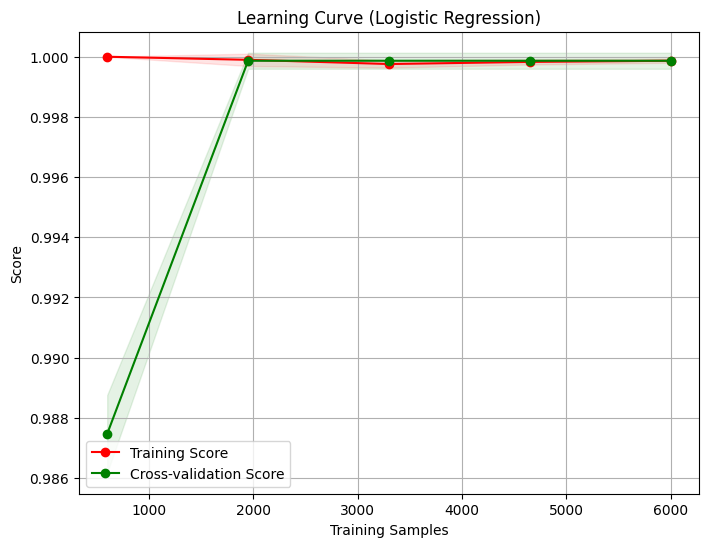

In [13]:
#collapse_output
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

# define the logistic regression model
#classifier = LogisticRegression()

# create a learning curve plot
train_sizes, train_scores, test_scores = learning_curve(
    classifier, X_train_tfidf, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot the learning curve
plt.figure(figsize=(8, 6))
plt.title('Learning Curve (Logistic Regression)')
plt.xlabel('Training Samples')
plt.ylabel('Score')
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
         label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
         label='Cross-validation Score')
plt.legend(loc='best')
plt.show()

Since the training score and cross-validation score are converging at a high value, this suggests the model has succesfully learned to distinguish between the drafting and non-drafting narratives.

That said, there is still a risk of overfitting -- i.e. the model has effectively "memorized" the dataset. One way of testing this is to try the model on more data to see whether it can generalize from the data it was trained on to make successful predictions in relation to new data.

Let's create some new docket narratives and run them through the model.

In [14]:
new_dockets = ["drafting motion record re: mareva injunction directed at bank and third parties", 
               "attending motion hearing re: challenging standing of proposed third party intervenor", 
               "participating in settlement conference re: laches issue", 
               "writing email to client re: laches issue"]

new_docket_counts = vectorizer.transform(new_dockets)
X_new_dockets_tfidf = tfidf_transformer.transform(new_docket_counts)

Now we'll run them through the model and check the results.

In [15]:
ynew = classifier.predict(X_new_dockets_tfidf)

for i in range(len(new_dockets)):
  if ynew[i] == 1:
    print("The docket narrative %r is a drafting docket. \n" % (new_dockets[i]))
  else:
    print("The docket narrative %r is not a drafting docket.\n" % (new_dockets[i]))

The docket narrative 'drafting motion record re: mareva injunction directed at bank and third parties' is a drafting docket. 

The docket narrative 'attending motion hearing re: challenging standing of proposed third party intervenor' is not a drafting docket.

The docket narrative 'participating in settlement conference re: laches issue' is not a drafting docket.

The docket narrative 'writing email to client re: laches issue' is a drafting docket. 



The model classifies these narratives accurately.

Note what happens, however, if we test it with "drafting" dockets where the drafting verb in the past tense. All of the training data is in the present tense.

In [16]:
new_dockets = ["drafted motion record re: mareva injunction directed at bank and others",  
               "wrote email to client re: laches issue"]

new_docket_counts = vectorizer.transform(new_dockets)
X_new_dockets_tfidf = tfidf_transformer.transform(new_docket_counts)

ynew = classifier.predict(X_new_dockets_tfidf)

for i in range(len(new_dockets)):
  if ynew[i] == 1:
    print("The docket narrative %r is a drafting docket. \n" % (new_dockets[i]))
  else:
    print("The docket narrative %r is not a drafting docket.\n" % (new_dockets[i]))

The docket narrative 'drafted motion record re: mareva injunction directed at bank and others' is not a drafting docket.

The docket narrative 'wrote email to client re: laches issue' is not a drafting docket.



As expected, the model classifies these dockets as "non-drafting" because it was not trained on any drafting verbs in the past tense.

# Final Thoughts

This was a fun exercise but ultimately the results are somewhat underwhelming. I think it highlights the shortcomings of my dataset. It contains only five drafting verbs (writing, drafting, editing, revising, briefing). The non-drafting narratives do not contain these verbs. This probably makes it easy for the model to "learn" to distinguish between the drafting and non-drafting dockets. The same result could also be accomplished using a simple if/then approach.

Still, I learned a lot and I'm fired up to apply these techniques to a more realistic dataset!

# Resources

I found the following resources particularly helpful for this project:
* [*Working with Text Data*, scikit-learn website](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
* [*Practical Text Classification with Python and Keras*, Real Python](https://realpython.com/python-keras-text-classification/) (see section on defining a baseline model)
* [*How to Make Predictions with scikit-learn*, Machine Learning Mastery](https://machinelearningmastery.com/make-predictions-scikit-learn/) 